In [55]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import ahkab
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.abc import f
from sympy import I
from scipy.constants import k
import scipy, scipy.interpolate
print("We're using ahkab %s" % ahkab.__version__)

We're using ahkab 0.18


In [2]:
# Build circuit.
# When components change, must rerun this cell for AC analysis to have new transfer function.
lpf = ahkab.Circuit('2nd Order Sallen-Key LPF')
# https://en.wikipedia.org/wiki/Sallen–Key_topology
Av = 100 #ideal voltage gain
ro = 200 #non-ideal output resistance
Cload = 40e-15
lpf.add_capacitor('CL', 'out', lpf.gnd, Cload) #load

lpf.add_resistor('R1', 'in', 'n1', 1e3)
lpf.add_isource('Inr1', 'in', 'n1', dc_value=0, ac_value=0) #R1 noise current
lpf.add_resistor('R2', 'n1', 'n2', 1e3)
lpf.add_isource('Inr2', 'n1', 'n2', dc_value=0, ac_value=0) #R2 noise current
lpf.add_capacitor('C1', 'n1', 'out', 1e-9)
lpf.add_capacitor('C2', 'n2', lpf.gnd, 1e-9)
lpf.add_vcvs('E1', 'out', lpf.gnd, 'n2', 'out', Av)
#lpf.add_resistor('RO', 'out', 'ne', ro) #DANGER: this blows up the solution
lpf.add_isource('Ine1', 'out', lpf.gnd, dc_value=0, ac_value=0) #op-amp total output noise current

# voltage sources for AC simulation
lpf.add_vsource('V1', 'in', lpf.gnd, dc_value=0, ac_value=1)
print(lpf)

* 2nd Order Sallen-Key LPF
CL out 0 4e-14
R1 in n1 1000
Inr1 in n1 type=idc value=0 
R2 n1 n2 1000
Inr2 n1 n2 type=idc value=0 
C1 n1 out 1e-09
C2 n2 0 1e-09
E1 out 0 n2 out 100
Ine1 out 0 type=idc value=0 
V1 in 0 type=vdc value=0 vac=1 


In [54]:
# Vin to Vout analysis
opa = ahkab.new_op()
aca = ahkab.new_ac(start=1e3, stop=1e9, points=100)
syma = ahkab.new_symbolic(source='V1')
r = ahkab.run(lpf, [opa, aca])
rs, tfs = ahkab.run(lpf, syma)['symbolic']
r['op'].keys()
r['ac'].keys()

# Print symbolic transfer function for input to output
#print(rs)
Hs = tfs['VOUT/V1']['gain']
print("Transfer function: %s" % Hs)
print("Poles: %s" % tfs['VOUT/V1']['poles'])
p0 = tfs['VOUT/V1']['poles'][0]
p1 = tfs['VOUT/V1']['poles'][1]

# Noise transfer functions for each source
rs_r1, tfs_r1 = ahkab.run(lpf, ahkab.new_symbolic(source='Inr1'))['symbolic']
rs_r2, tfs_r2 = ahkab.run(lpf, ahkab.new_symbolic(source='Inr2'))['symbolic']
rs_e1, tfs_e1 = ahkab.run(lpf, ahkab.new_symbolic(source='Ine1'))['symbolic']
Hs_r1 = tfs_r1['VOUT/INR1']['gain']
Hs_r2 = tfs_r2['VOUT/INR2']['gain']
Hs_e1 = tfs_e1['VOUT/INE1']['gain']
print("R1 noise current TF: %s" % Hs_r1)
print("R2 noise current TF: %s" % Hs_r2)
print("Opamp noise current TF: %s" % Hs_e1)

['VOUT', 'VIN', 'VN1', 'VN2', 'I(E1)', 'I(V1)']

['f', 'Vout', 'Vin', 'Vn1', 'Vn2', 'I(E1)', 'I(V1)']

Transfer function: 1/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
Poles: [0.5*(-sqrt(C2)*(R1 + R2) + sqrt(-4.0*C1*R1*R2 + C2*R1**2 + 2.0*C2*R1*R2 + C2*R2**2))/(C1*sqrt(C2)*R1*R2), -0.5*(sqrt(C2)*(R1 + R2) + sqrt(-4.0*C1*R1*R2 + C2*R1**2 + 2.0*C2*R1*R2 + C2*R2**2))/(C1*sqrt(C2)*R1*R2)]
R1 noise current TF: R1/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
R2 noise current TF: R2*(C1*R1*s + 1)/(C1*C2*R1*R2*s**2 + C2*R1*s + C2*R2*s + 1.0)
Opamp noise current TF: 0


In [100]:
# Evaluate w/ chosen R & C values.
# TODO: solve for these values using Sympy

Rbase = 500
m = 2
Cbase = 10e-12
n = 2
R1val = Rbase*m
R2val = Rbase/m
C1val = Cbase*m
C2val = Cbase/m

s, R1, R2, C1, C2 = rs.as_symbols('s R1 R2 C1 C2')
#s, R1, R2, C1, C2, E1, RO, CL = rs.as_symbols('s R1 R2 C1 C2 E1 RO CL') # w/ non-zero ro

# Passband/stopband
HS = sp.lambdify(f, Hs.subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val})) #, E1:Av, RO:ro, CL:Cload}))
print("DC gain from symbolic analysis: %g dB" % (20*np.log10(np.abs(HS(0)))))
print("Maximum attenuation in the pass band (0-%g Hz) is %g dB" % (20e6, -20*np.log10(np.abs(HS(20e6)))))
print("Minimum attenuation in the stop band (%g Hz - Inf) is %g dB" % (200e6, -20*np.log10(np.abs(HS(200e6)))))

# Poles
p0s = p0.subs({R1:R1val, R2:R2val, C1:C1val, C2:C2val})/2/np.pi
p1s = p1.subs({R1:R1val, R2:R2val, C1:C1val, C2:C2val})/2/np.pi
print("First pole: %g + %gj Hz (%g)" % (sp.re(p0s), sp.im(p0s), sp.Abs(p0s)))
print("Second pole: %g + %gj Hz (%g)" % (sp.re(p1s), sp.im(p1s), sp.Abs(p1s)))

# Find how much input referred integrated noise there is
# Then check if DR is achievable based on supply & V*
print("Simulation temp: %g K" % ahkab.constants.Tref)
kT4 = 4*k*ahkab.constants.Tref
# Assume all opamp noise is from a single transistor w/ some effective gm
gamma = 2/3
gm = 0.005
in2_r1 = kT4/R1val
in2_r2 = kT4/R2val
in2_e1 = kT4*gamma*gm
vi2_r1 = sp.integrate(sp.Abs(((Hs_r1/Hs).subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))**2) * in2_r1, (f, 0, 20e6))
print("Input referred noise power from R1: %g V^2" % vi2_r1)
vi2_r2 = sp.integrate(sp.Abs(((Hs_r2/Hs).subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))**2) * in2_r2, (f, 0, 20e6))
print("Input referred noise power from R2: %g V^2" % vi2_r2)
vi2_e1 = sp.integrate(sp.Abs(((Hs_e1/Hs).subs({s:I*f*2*np.pi, R1:R1val, R2:R2val, C1:C1val, C2:C2val}))**2) * in2_e1, (f, 0, 20e6))
print("Input referred noise power from opamp: %g V^2" % vi2_e1)
vi2_tot = (vi2_r1 + vi2_r2 + vi2_e1).evalf()
print("Total input referred noise power: %g V^2" % vi2_tot)
SNR = 10**(50/10)
vi_min = sp.sqrt(vi2_tot*SNR*2)
print("Min. voltage (zero-pk): %g" % vi_min)
Vstar = 0.1 #assumption
print("Voltage swing attainable? %r" % (vi_min < 0.6-Vstar))

DC gain from symbolic analysis: 0 dB
Maximum attenuation in the pass band (0-2e+07 Hz) is -0.0738619 dB
Minimum attenuation in the stop band (2e+08 Hz - Inf) is 31.8816 dB
First pole: -1.98944e+07 + 2.48481e+07j Hz (3.1831e+07)
Second pole: -1.98944e+07 + -2.48481e+07j Hz (3.1831e+07)
Simulation temp: 300 K
Input referred noise power from R1: 3.31356e-10 V^2
Input referred noise power from R2: 2.57258e-10 V^2
Input referred noise power from opamp: 0 V^2
Total input referred noise power: 5.88613e-10 V^2
Min. voltage (zero-pk): 0.01085
Voltage swing attainable? True


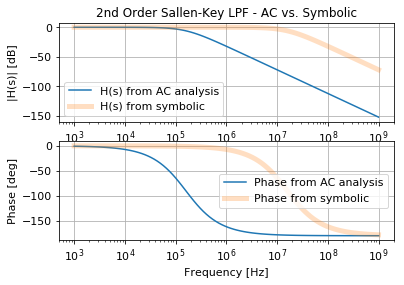

In [98]:
fig = plt.figure()
plt.subplot(211)
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(r['ac']['Vout'])), '-', label='H(s) from AC analysis')
plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='H(s) from symbolic')
#plt.semilogx(r['ac']['f'], 20*np.log10(np.abs(HS_r1(r['ac'].get_x()))), '-', label='H(s) from resistor to output')
plt.ylabel('|H(s)| [dB]')
plt.title(lpf.title + " - AC vs. Symbolic")
plt.legend(); plt.grid(True);
plt.subplot(212)
plt.semilogx(r['ac']['f'], 180/np.pi*np.angle(r['ac']['Vout']), '-', label='Phase from AC analysis')
plt.semilogx(r['ac']['f'], 180/np.pi*(np.angle(HS(r['ac'].get_x()))), '-', lw=5, alpha=.25, label='Phase from symbolic')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [deg]')
#fig.savefig('ac_plot.png')
plt.legend(); plt.grid(True);
plt.show();

In [70]:
# Check against AC simulation
# DC gain
dc_gain = 20*np.log10(np.abs(r['ac']['Vout'][0]))
print("DC gain from AC analysis: %g dB" % (dc_gain))

# Normalize the output to the low frequency value and convert to array
norm_out = np.abs(r['ac']['Vout'])/np.abs(r['ac']['Vout']).max()
# Convert to dB
norm_out_db = 20*np.log10(norm_out)
# Get frequencies
frequencies = r['ac']['f']
# call scipy to interpolate
norm_out_db_interpolated = scipy.interpolate.interp1d(frequencies, norm_out_db)

print("Maximum attenuation in the pass band (0-%g Hz) is %g dB" % (20e6, -1.0*norm_out_db_interpolated(20e6)))
print("Minimum attenuation in the stop band (%g Hz - Inf) is %g dB" % (200e6, -1.0*norm_out_db_interpolated(200e6)))

DC gain from AC analysis: -0.000342924 dB
Maximum attenuation in the pass band (0-2e+07 Hz) is 83.9631 dB
Minimum attenuation in the stop band (2e+08 Hz - Inf) is 123.926 dB
